# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [96]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return 1.0 / (1.0 + np.exp(-(X @ weights)))
    
    def get_loss_history(self):
        return self.loss_history
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        return np.mean(np.log(1.0 + np.exp(-(x @ weights) * y))) + (np.linalg.norm(weights) ** 2) / (2 * self.C)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        self.loss_history = np.zeros(self.max_iter)
        
        for i in range(self.max_iter):
            
            self.loss_history[i] = self.get_loss(X_ext, self.weights_, y)
            
            reg_part = self.weights_ / self.C
            exp_part = ( 1.0 - ( 1.0 / ( 1.0 + np.exp( -( ( X_ext @ self.weights_ ) * y ) ) ) ) )
            delta = -np.mean(y.T * (X_ext.T * exp_part.T), axis=1) + reg_part
            self.weights_ -= self.eta * delta
            if np.linalg.norm(self.eta * delta) < self.tol:
                self.loss_history.resize((i,1))
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        
        return np.round(2.0 * (self.predict_proba(X) >= 0.5) - 1)

In [5]:
from sklearn import datasets
from sklearn import metrics

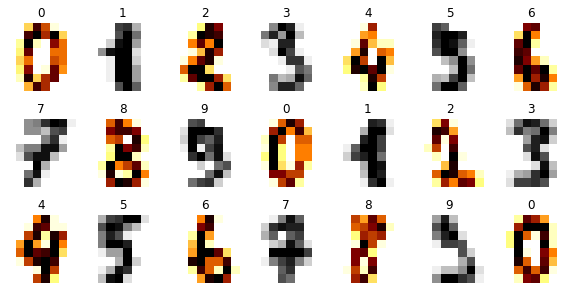

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test, ax=None):
    clf.fit(X_train, y_train)
    cm = confusion_matrix(y_test, clf.predict(X_test), normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm) #здесь реализацию авторов сменила на новую, та была deprecated
    disp.plot(ax=ax)
    disp.figure_.suptitle("Confusion Matrix")
    # plt.show() - закомментила, чтобы выводить subplots
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

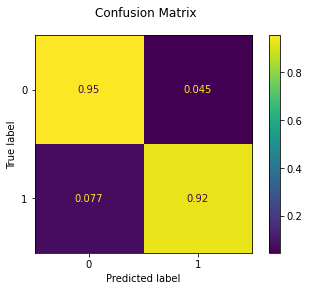

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [17]:
def plot_loss_function(model, ax=plt):
    ax.plot(model.get_loss_history())
    plt.xlabel('Iteration №')
    plt.ylabel('Loss')
    ax.grid(True)
    plt.title('Loss function by iteration number')

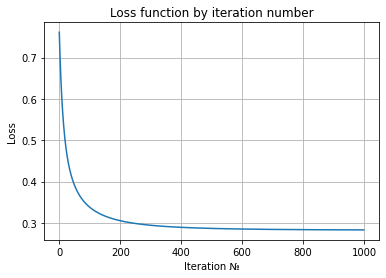

In [18]:
plot_loss_function(model)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

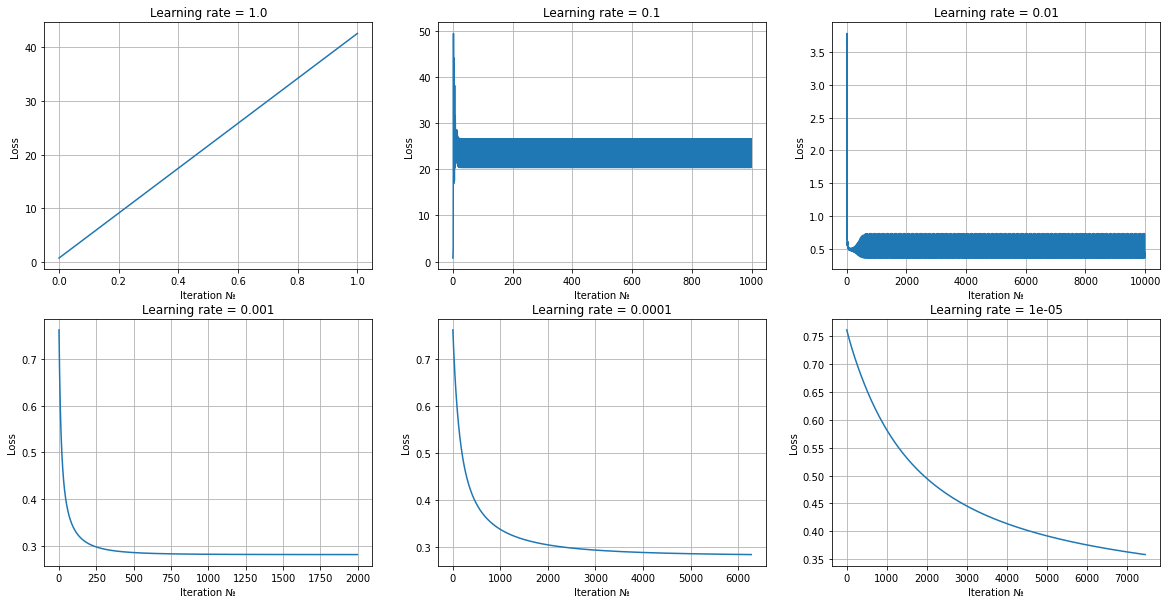

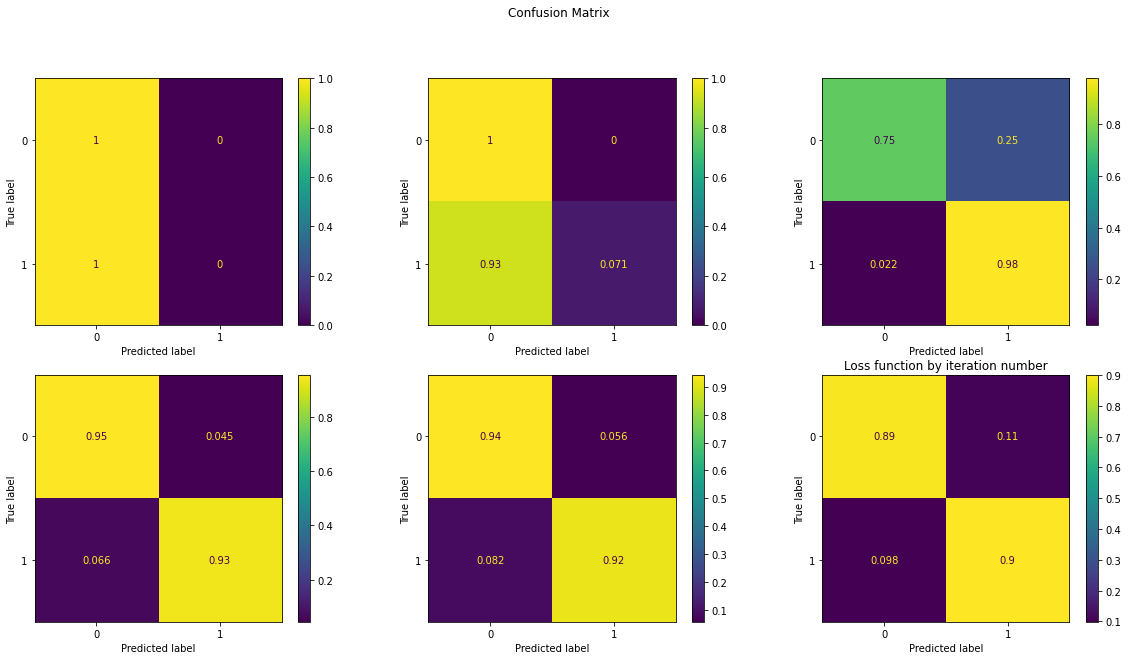

In [20]:
learning_rates = np.logspace(0, -5, 5 + 1)
plots_col_num = 3
fig_loss, axs_loss = plt.subplots(2, plots_col_num, figsize = (20, 10))
fig_conf, axs_conf = plt.subplots(2, plots_col_num, figsize = (20, 10))
plt_ctr = 0
for learning_rate in learning_rates:
    model = CustomLogisticRegression(eta=learning_rate, max_iter=int(100/learning_rate))
    model.fit(X_train, y_train)
    axs_curr_loss = axs_loss[int(plt_ctr/plots_col_num), plt_ctr%plots_col_num]
    axs_curr_conf = axs_conf[int(plt_ctr/plots_col_num), plt_ctr%plots_col_num]
    plot_loss_function(model, axs_curr_loss)
    fit_evaluate(model, X_train, y_train, X_test, y_test, axs_curr_conf)
    axs_curr_loss.set_title(f'Learning rate = {learning_rate}')
    axs_curr_loss.set_xlabel('Iteration №')
    axs_curr_loss.set_ylabel('Loss')
    plt_ctr += 1

*Так как при снижении learning rate сходимость наступает позже, max_iter обратно пропорционален learning rate*

* **Learning rate = 10^ 0** - Алгоритм обучения расходится, функция потерь линейно возрастает. Начинаются числовые переполнения после взятия экспоненты (Warning)
* **Learning rate = 10^-1** - Алгоритм сходится (~30 итераций), но нестабильно, есть сильные пульсации около нуля. Видимо не удаётся достичь минимума, прыгаем неподалёку.
* **Learning rate = 10^-2** - Алгоритм сходится (~30 итераций), пульсации значительно уменьшились по модулю, но минимума опять не достигли.
* **Learning rate = 10^-3** - Алгоритм сходится, пусть и медленнее, чем раньше, но пульсаций не видно. После ~500 начали нащупывать минимум, около ~2000 смогли пройти условие по tol
* **Learning rate = 10^-4** - Алгоритм сходится ещё медленнее, в районе ~3000 начали нащупывать минимум, около ~6500 смогли пройти условие по tol
* **Learning rate = 10^-5** - Алгоритм сходится ещё медленнее, около ~7000 смогли пройти условие по tol

Итого:
* Если шаг обучения слишком велик, минимум найти не удаётся и алгоритм расходится (eta = 1)
* Также шаг обучения может быть достаточным, чтоб нащупать минимум, но слишком высокий, чтоб спуститься к нему близко. Возникают пульсации функции потерь. (eta = 10^-1, 10^-2)
* Если шаг обучения подобран хорошо, алгоритм будет сходиться с некой скоростью к минимуму и в конце концов минимум будет найден и изменение весов станет ниже Tol. (eta = 10^-3, 10^-4, 10^-5)

В нашем случае наилучший результат достигается при eta=10^-3, так как за минимально возможное число итераций при данных значениях всех eta удаётся достичь минимума функции потерь с точностью Tol.
Видимо чуть раньше это значение выбрали не просто так
Confusion matrix тоже лучшая для 10^-3. Тут максимизируется TP и TN и минимизируются FP, FN.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

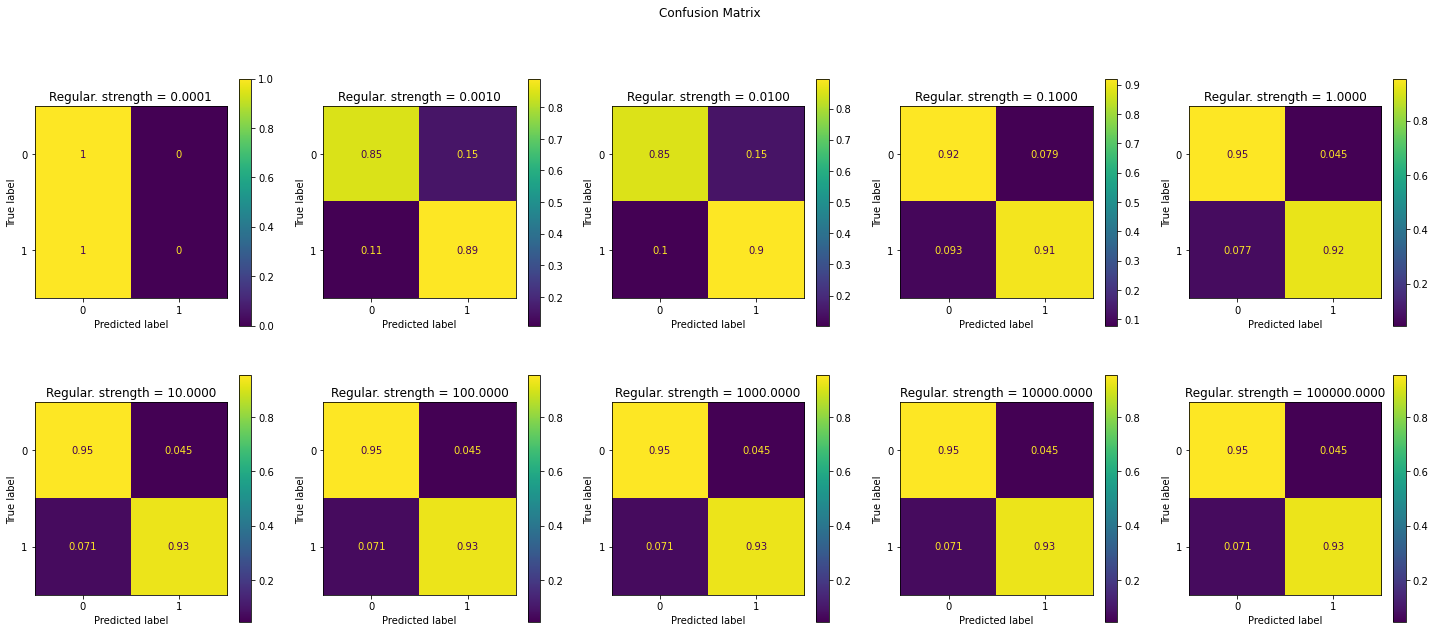

In [27]:
eta = 0.001 #из прошлого задания лучший вариант
# regular_strengths = np.linspace(1, 0, 10, endpoint=False)
regular_strengths = np.logspace(-4, 5, 10)
plots_col_num = 5
fig, axs = plt.subplots(2, plots_col_num, figsize = (25, 10))
plt_ctr = 0

for regular_strength in regular_strengths:
    axs_curr = axs[int(plt_ctr/plots_col_num), plt_ctr%plots_col_num]
    model = CustomLogisticRegression(eta=eta, C=regular_strength)
    fit_evaluate(model, X_train, y_train, X_test, y_test, axs_curr)
    axs_curr.set_title("Regular. strength = {:.4f}".format(regular_strength))
    plt_ctr += 1

Чем меньше число C, тем сильнее вклад значений весов в функцию потерь (тем сильнее регуляризация). Попробовала усиливать регуляризацию, при значениях 10^-4, 10^-3 происходили численные переполнения из-за слишком больших чисел - в результате такая модель оказалась вообще неработоспособной. Все остальные значения < 1 ухудшали характеристики модели (увеличивали ошибки 1 и 2го рода - FN, FP, снижали кол-во правильно идентифицированных объектов - TN, TP).
При значениях значительно выше 1 качество модели практически не изменилось...
Вывод какой-то неоднозначный - по какой-то причине применение регуляризации ухудшает качество модели... По идее смысл регуляризации именно в ограничении весов, а не в улучшении качества модели

In [31]:
model_strong_reg = CustomLogisticRegression(eta=eta, C=0.001)
model_weak_reg = CustomLogisticRegression(eta=eta, C=1)
model_strong_reg.fit(X_train, y_train)
model_weak_reg.fit(X_train, y_train)
np.mean(np.abs(model_weak_reg.weights_)) / np.mean(np.abs(model_strong_reg.weights_))

68.87073905413939

Регуляризация с C=0,001 снизила средний модуль весов в ~70 раз относительно модели с C=1. Короче регуляризация работает как надо, но почему-то ухудшает качество модели. Предположение: в линейной модели понижается угол наклона таким образом, а здесь видимо сигмоида расползается и мы как бы для бОльшего количества объектов начинаем предсказывать вероятности между 0 и 1, а конкретно в районе 0,5. Скорее всего больше объектов начинает путаться при более мягком условии

**(0.5 points)** Compare zero initialization and random initialization. 

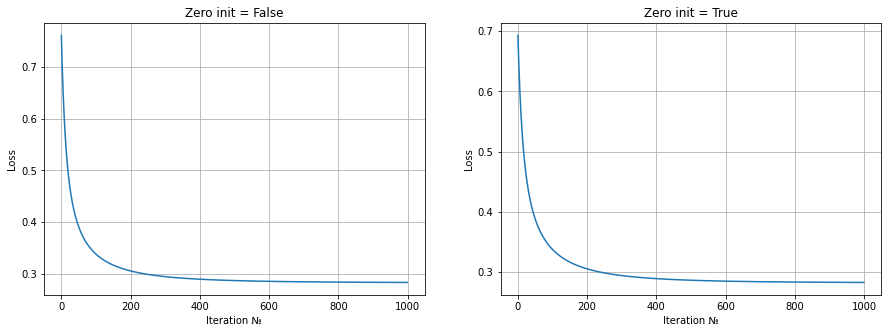

In [32]:
zero_inits = [False, True]
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
plt_ctr = 0
for zero_init in zero_inits:
    model = CustomLogisticRegression(zero_init=zero_init)
    model.fit(X_train, y_train)
    axs_curr = axs[plt_ctr]
    plot_loss_function(model, axs_curr)
    axs_curr.set_title(f'Zero init = {zero_init}')
    axs_curr.set_xlabel('Iteration №')
    axs_curr.set_ylabel('Loss')
    plt_ctr += 1

Разницы практически никакой в конкретно данном случае.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [33]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        P = np.zeros(shape=(X.shape[0], Y.shape[0]))
        for X_ctr in range(X.shape[0]):
            for Y_ctr in range(Y.shape[0]):
                P[X_ctr, Y_ctr] = np.linalg.norm(X[X_ctr,:] - Y[Y_ctr,:])
        return P
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samples,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        p = np.zeros(shape=(len(self.classes_)))
        for class_ctr in range(len(self.classes_)):
            class_curr = self.classes_[class_ctr]
            p[class_ctr] = np.sum(weights[np.where(y == class_curr)])
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1.0 / (self.eps + P)
            
            proba = np.zeros(shape=(X.shape[0], len(self.classes_)))
            sorted_P = np.argsort(P, axis=1)
            nearest_neigh_indxs = sorted_P[:, 0:self.n_neighbors]
            
            for ctr in range(X.shape[0]):
                weights_sum = self.get_class_weights(self.y[nearest_neigh_indxs[ctr,:]], weights_of_points[ctr, nearest_neigh_indxs[ctr,:]])
                proba[ctr, :] = weights_sum.T / np.sum(weights_sum)
                
            return proba
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        preds = np.zeros(X.shape[0])
        max_indxs = np.argmax(self.predict_proba(X), axis=1)
        for ctr in range(X.shape[0]):
            preds[ctr] = self.classes_[max_indxs[ctr]]
            
        return preds

In [34]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [35]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [36]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

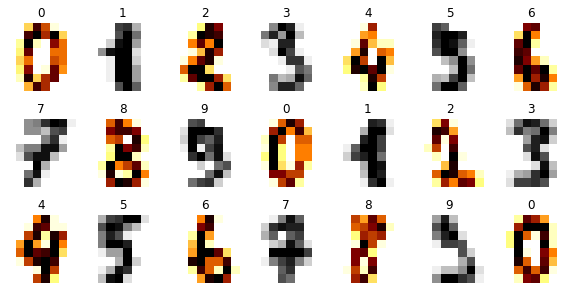

In [37]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [38]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [39]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

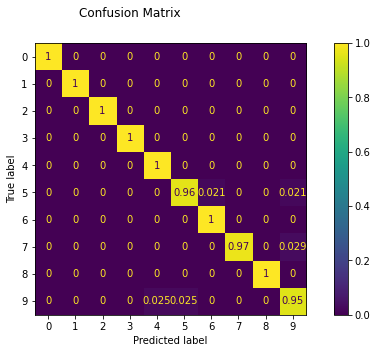

In [40]:
plt.rcParams["figure.figsize"] = (10, 5)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [41]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

Проблемы возникли с распознаванием чисел 5, 7, 9 - они распознаются чуть хуже, чем другие. Видимо они периодически похожи на другие числа. По матрице видно, что были перепутаны: 5 и 9, 4 и 9, 5 и 6, 7 и 9. Если посмотреть на картинки перепутанных чисел, то видно, что их силуэты бывают похожи, отсюда и путаница

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

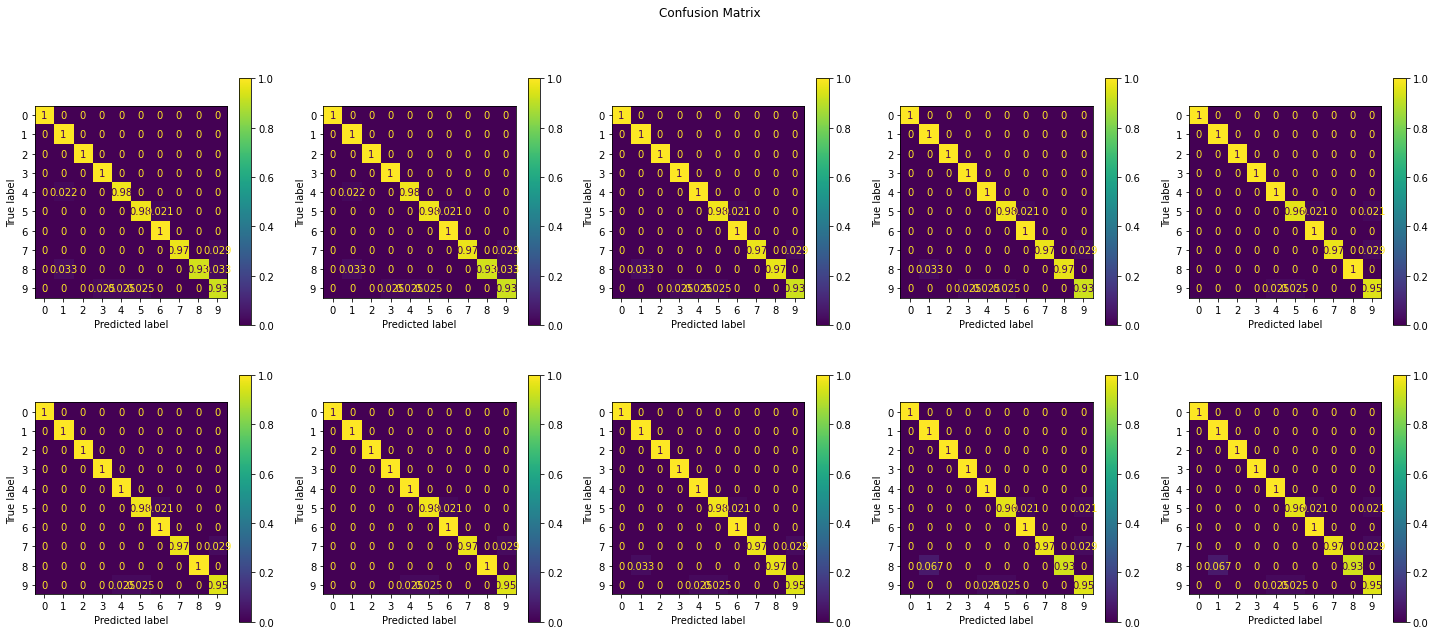

In [42]:
n_neighbors = np.linspace(1, 10, 10).astype(int)
n_neighbors
plots_col_num = 5
fig, axs = plt.subplots(2, plots_col_num, figsize = (30, 10))
plt_ctr = 0

for n_neighbor in n_neighbors:
    axs_curr = axs[int(plt_ctr/plots_col_num), plt_ctr%plots_col_num]
    model = CustomKNeighborsClassifier(n_neighbors=n_neighbor, weights='distance')
    model.fit(X_train, y_train)
    fit_evaluate(model, X_train, y_train, X_test, y_test, axs_curr)
    axs_curr.set_title(f"{n_neighbor} neighbours")
    plt_ctr+=1

< your thoughts >

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

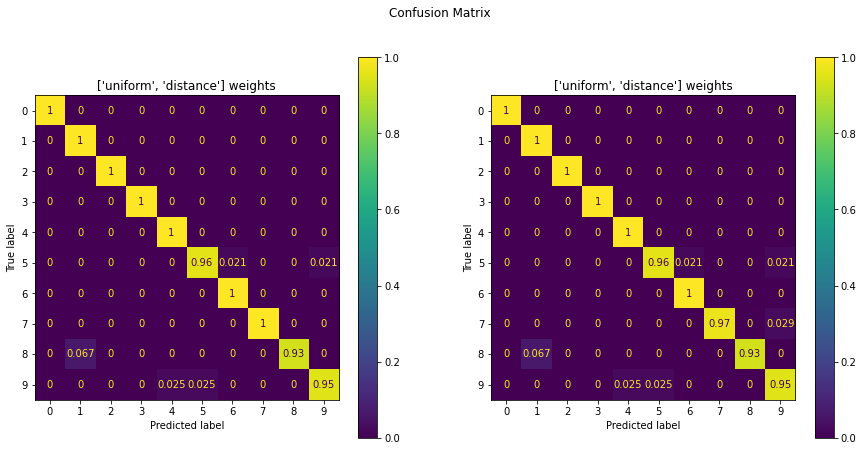

In [44]:
weight_types = ['uniform', 'distance']
plots_col_num = 2
fig, axs = plt.subplots(1, plots_col_num, figsize = (15, 7))
plt_ctr = 0

for weight_type in weight_types:
    axs_curr = axs[plt_ctr%plots_col_num]
    model = CustomKNeighborsClassifier(n_neighbors=n_neighbor, weights=weight_type)
    model.fit(X_train, y_train)
    fit_evaluate(model, X_train, y_train, X_test, y_test, axs_curr)
    axs_curr.set_title(f"{weight_type} weights")
    plt_ctr+=1

Почему-то вариант с uniform весами не путает 7 и 9. Больше особых отличий нет.

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [45]:
PATH = "./data/"

In [46]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [47]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

male      0.56114
female    0.43886
Name: Sex, dtype: float64

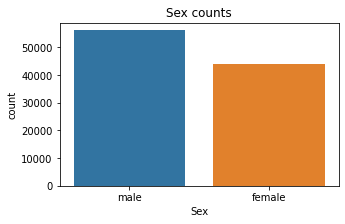

In [67]:
plt.rcParams["figure.figsize"] = (5, 3)
sns.countplot(data=data, x='Sex')
plt.title('Sex counts');
data['Sex'].value_counts() / data.shape[0]

0.42774

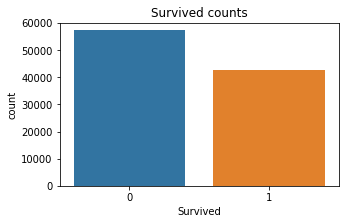

In [68]:
sns.countplot(data=data, x='Survived')
plt.title('Survived counts');
data['Survived'].mean()

Sex
female    0.711525
male      0.205795
Name: Survived, dtype: float64

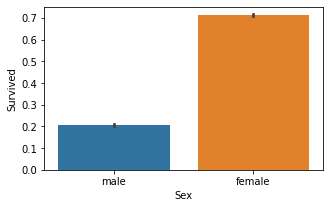

In [69]:
sns.barplot(data=data, x='Sex', y='Survived')
data.groupby('Sex')['Survived'].mean()

Мужчин на корабле было больше, чем женщин (56% и 43% соответственно). Выжило 42% людей (из этих выживших 71% женщин и 20% мужчин). Отсюда вывод - женщин спасали значительно чаще.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

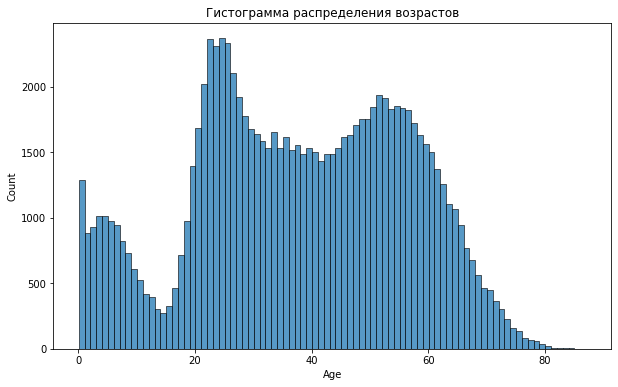

In [72]:
plt.rcParams["figure.figsize"] = (10, 6)
plt.title('Гистограмма распределения возрастов')
sns.histplot(data['Age'], binwidth=1)
data['Age'].describe()

Средний возраст пассажиров - 38 лет. Распределение немного странное - видно, что у него 3 доминанты - 5, 25, 50 лет.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

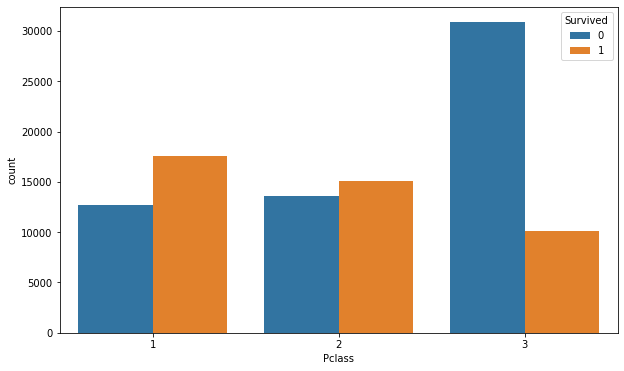

In [73]:
sns.countplot(data=data, x='Pclass', hue='Survived');

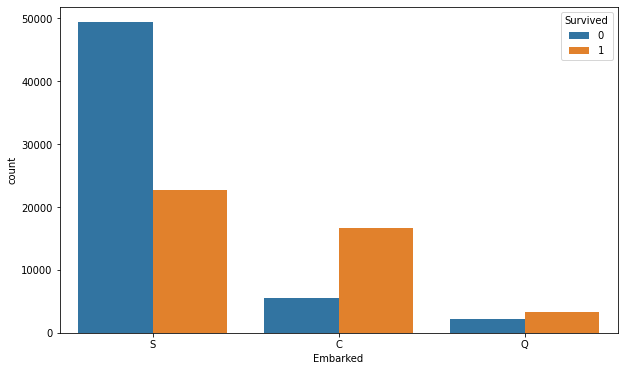

In [74]:
sns.countplot(data=data, x='Embarked', hue='Survived');

* Видно, что выживаемость зависит от переменной Pclass. По какой-то причине самая низкая выживаемость в Pclass=3 (24%). Самая высокая выживаемость для Pclass=1 составила 57%. Судя по описанию к датасету 3й класс соответствует самому низкому социальному и экономическому статусу. Следовательно, богатых спасали гораздо чаще, чем бедных.
* Люди, выплывшие из C (Cherbourg) выживали чаще (75% выживших из людей, выплыших из C). На втором месте Q (Queenstown) - 59%. На третьем месте S (Southampton) - 31%. Не понятно откуда взялась такая ярко-выраженная зависимость. Нужно посмотреть связь Embarked и Pclass. Видим, что есть связь. Наибольше соотношение богатых к бедным в C и Q. В S больше наоборот бедных. Поэтому люди из S умирали чаще.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

Survived    0.00000
Pclass      0.00000
Name        0.00000
Sex         0.00000
Age         0.03292
SibSp       0.00000
Parch       0.00000
Ticket      0.04623
Fare        0.00134
Cabin       0.67866
Embarked    0.00250
dtype: float64


Text(0.5, 0, 'Column name')

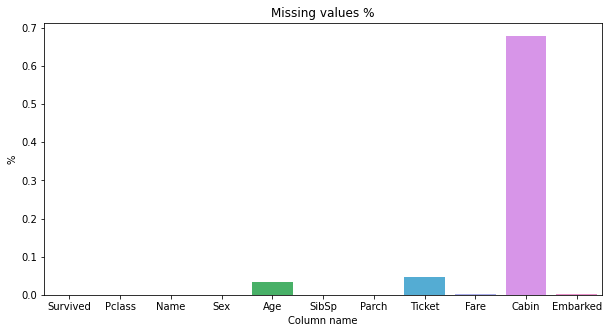

In [58]:
miss_share = data.isna().sum() / data.shape[0]
print(miss_share)
plt.rcParams["figure.figsize"] = (10, 5)
sns.barplot(x=miss_share.index, y=miss_share.values)
plt.title('Missing values %');
plt.ylabel('%')
plt.xlabel('Column name')

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

Наибольшее количество пропущенных значений у Cabin.
Возможные варианты обработки значений:
1) Выкидывание целых строк с NaN. 
    + Достоинства: Просто и быстро. Не будем вносить ошибочные данные
    + Недостатки: Потеряем кучу данных
2) Заполнение медианным значением
    + Достоинства: оставим себе полный датасет. С большой долей вероятности угадаем значение
    - Недостатки: если колонка - это номер билета, то угадать через медиану скорее всего не получится. Ошибки у такого метода всё же будут
    
Ввиду маленького датасета используем второй способ

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

**Здесь основываюсь в основном на результатах предыдущего своего ноутбука https://github.com/zappaz00/2_data_exploration/blob/master/eda.ipynb**

In [91]:
data_prepared = data.copy()
data_prepared = data_prepared.drop(['Name', 'Ticket'], axis=1)
data_prepared['Rel'] = data_prepared['SibSp'] + data_prepared['Parch']
data_prepared['Cabin'] = data_prepared['Cabin'].apply(lambda s: s[0] if isinstance(s, str) else None)

cabin_value_counts = data_prepared['Cabin'].value_counts()
embarked_value_counts = data_prepared['Embarked'].value_counts()

data_prepared['Age'][data_prepared['Age'].isna()] = data_prepared['Age'].median()
data_prepared['Fare'][data_prepared['Fare'].isna()] = data_prepared['Fare'].median()
data_prepared['Cabin'][data_prepared['Cabin'].isna()] = cabin_value_counts.index[cabin_value_counts.argmax()]
data_prepared['Embarked'][data_prepared['Embarked'].isna()] = embarked_value_counts.index[embarked_value_counts.argmax()]

data_prepared['Cabin'] = pd.factorize(data_prepared['Cabin'])[0]
data_prepared['Sex'] = pd.factorize(data_prepared['Sex'])[0]
data_prepared['Embarked'] = pd.factorize(data_prepared['Embarked'])[0]

data_prepared.isna().sum().sum()

0

In [92]:
data_prepared.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Rel
PassengerId,,,,,,,,,,
0,1,1,0,39.00,2,0,27.14,0,0,2
1,0,3,0,39.00,0,0,13.35,0,0,0
2,0,3,0,0.33,1,2,71.29,0,0,3
3,0,3,0,19.00,0,0,13.04,0,0,0
4,1,3,0,25.00,0,0,7.76,0,0,0


In [93]:
X = data_prepared[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Rel']]
y = data_prepared['Survived']

Пришлось использовать реализации sklearn, так как кросс-валидация просит специальные функции, которые мы не реализовывали. Плюс у моего kNN тяжеловато с производительностью

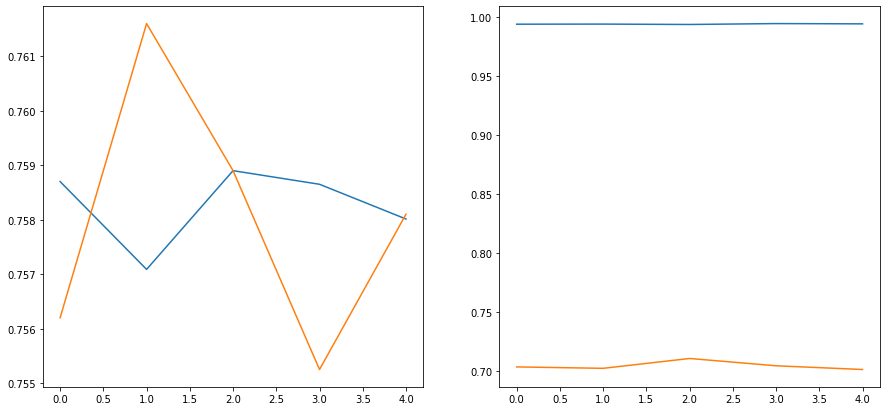

In [106]:
knn_clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
lr_clf = LogisticRegression()

knn_result = cross_validate(knn_clf, X, y, cv=5, return_train_score=True, return_estimator=True, scoring='accuracy')
lr_result = cross_validate(lr_clf, X, y, cv=5, return_train_score=True, return_estimator=True, scoring='accuracy')

fig, axs = plt.subplots(1, 2, figsize = (15, 7))
axs[0].plot(lr_result['train_score'], label='Train')
axs[0].plot(lr_result['test_score'], label='Test')
axs[0].set_title('LR')
axs[0].set_xlabel('CV fold')
axs[1].plot(knn_result['train_score'], label='Train')
axs[1].plot(knn_result['test_score'], label='Test')
axs[1].set_title('kNN')
axs[1].set_xlabel('CV fold')

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

In [104]:
y_pred = knn_result['estimator'][0].predict(X)
np.savetxt("titanic_pred.csv", y_pred, delimiter=",")

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.